In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from model_settings import ms

ms.find_root(Path())

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

# loading model

In [3]:
root = os.path.join(ms.root,ms.MacDirEx)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 124653897492 cboe spx relative barrier
1     2024-11-09 112825652640 cboe spx relative asian


In [4]:
selected_model = models.iloc[1]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 0           1274.0        637.00                 7        1.0   
 1           1274.0        637.00                 7        1.0   
 2           1274.0        637.00                 7        1.0   
 3           1274.0        637.00                 7        1.0   
 4           1274.0        955.50                 7        1.0   
 ...            ...           ...               ...        ...   
 338935      5857.0       7320.75                84        1.0   
 338936      5857.0       8785.00                84        1.0   
 338937      5857.0       8785.00                84        1.0   
 338938      5857.0       8785.00                84        1.0   
 338939      5857.0       8785.00                84        1.0   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                      7             0      geometric  call        0.001578   
 1                 

In [5]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [6]:
unretrained = model['model']

In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

fixing frequency: 
0     7
1    28
2    84
Name: fixing_frequency, dtype: int64

past fixings: 
0    0
Name: past_fixings, dtype: int64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e-09
            ...     
1747    6.161121e+01
1748    6.214923e+01
1749    6.690466e+01
1750    8.814194e+01
1751    1.158504e+02
Name: kappa, Length: 1752, dtype: float64

th

In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])

['days_to_maturity', 'fixing_frequency', 'past_fixings', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'relative_spot', 'averaging_type', 'w']


# retraining

In [9]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [36]:
test_dates = model['test_dates']
full_dataset = model['dataset']
pricename = [f[:f.find('_',0)] for f in full_dataset.columns if f.find('asian_price')!=-1 or f.find('barrier_price')!=-1][0]
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')
# i = 0
# for date in all_dates:
#     i += 1
#     plt.scatter(date,i)

retraining_frequency = 20

n = model['test_dates'].shape[0]//retraining_frequency

In [37]:
test_data.columns

Index(['spot_price', 'strike_price', 'days_to_maturity', 'n_fixings',
       'fixing_frequency', 'past_fixings', 'averaging_type', 'w',
       'risk_free_rate', 'dividend_rate', 'calculation_date', 'kappa', 'theta',
       'rho', 'eta', 'v0', 'date', 'asian_price', 'relative_spot',
       'relative_asian_price', 'relative_observed'],
      dtype='object')

In [65]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame(np.tile(np.nan,(n+1,len(cols))),columns=cols)

models = {}


for i in range(0,n):
    development_dates = pd.to_datetime(model['development_dates'],format='mixed')
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    print(f"training:  {min(development_dates).strftime('%A, %d %B, %Y')}  -  {max(development_dates).strftime('%A, %d %B, %Y')} ({len(development_dates)} trading days)")
    print(f"testing:   {min(subset_test_dates).strftime('%A, %d %B, %Y')}  -  {max(subset_test_dates).strftime('%A, %d %B, %Y')} ({len(subset_test_dates)} trading days)")
    test_data = full_dataset[full_dataset['date'].isin(subset_test_dates)]

    target = test_data['relative_observed']
    prediction = unretrained.predict(test_data[model['feature_set']])
    error = prediction-target
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    print(df.dropna())
    print('\n','%'*10,'\n')

training:  Tuesday, 03 January, 2012  -  Monday, 05 November, 2012 (100 trading days)
testing:   Tuesday, 06 November, 2012  -  Thursday, 24 January, 2013 (20 trading days)
                     outofsample_MAE  outofsample_RMSE
2012-11-06 00:00:00         0.005963           0.00963

 %%%%%%%%%% 

training:  Tuesday, 03 January, 2012  -  Monday, 05 November, 2012 (100 trading days)
testing:   Monday, 04 February, 2013  -  Wednesday, 24 April, 2013 (20 trading days)
                     outofsample_MAE  outofsample_RMSE
2012-11-06 00:00:00         0.005963          0.009630
2013-02-04 00:00:00         0.003528          0.005019

 %%%%%%%%%% 

training:  Tuesday, 03 January, 2012  -  Monday, 05 November, 2012 (100 trading days)
testing:   Thursday, 25 April, 2013  -  Friday, 07 June, 2013 (20 trading days)
                     outofsample_MAE  outofsample_RMSE
2012-11-06 00:00:00         0.005963          0.009630
2013-02-04 00:00:00         0.003528          0.005019
2013-04-25 00:00:00 

In [66]:
model['test_data']

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,eta,v0,date,asian_price,relative_spot,relative_asian_price,relative_observed,outofsample_target,outofsample_prediction,outofsample_error
23580,1425.0,712.00,7,1.0,7,0,geometric,call,0.001675,0.021159,...,1.861134,0.105190,2012-11-06,712.549220,2.001404,0.986432,0.986432,0.986432,0.999492,0.013061
23695,1425.0,1780.75,84,1.0,84,0,arithmetic,put,0.001675,0.021159,...,1.861134,0.105190,2012-11-06,358.884247,0.800225,0.202240,0.202240,0.202240,0.205665,0.003425
23696,1425.0,2137.00,84,1.0,84,0,geometric,call,0.001675,0.021159,...,1.861134,0.105190,2012-11-06,0.000000,0.666823,0.000000,0.000000,0.000000,0.002160,0.002160
23697,1425.0,2137.00,84,1.0,84,0,geometric,put,0.001675,0.021159,...,1.861134,0.105190,2012-11-06,715.894262,0.666823,0.328607,0.328607,0.328607,0.335539,0.006931
23698,1425.0,2137.00,84,1.0,84,0,arithmetic,call,0.001675,0.021159,...,1.861134,0.105190,2012-11-06,0.000000,0.666823,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338695,5863.0,7328.25,84,1.0,84,0,arithmetic,put,0.041813,0.012687,...,6.124247,0.000915,2024-10-14,1432.480205,0.800055,0.193646,0.193646,0.193646,2.544380,2.350734
338694,5863.0,7328.25,84,1.0,84,0,arithmetic,call,0.041813,0.012687,...,6.124247,0.000915,2024-10-14,0.031726,0.800055,0.000004,0.000004,0.000004,2.366951,2.366946
338693,5863.0,7328.25,84,1.0,84,0,geometric,put,0.041813,0.012687,...,6.124247,0.000915,2024-10-14,1437.338195,0.800055,0.193161,0.193161,0.193161,2.478430,2.285269
338691,5863.0,5862.50,84,1.0,84,0,arithmetic,put,0.041813,0.012687,...,6.124247,0.000915,2024-10-14,72.837863,1.000085,0.012327,0.012327,0.012327,2.441514,2.429187


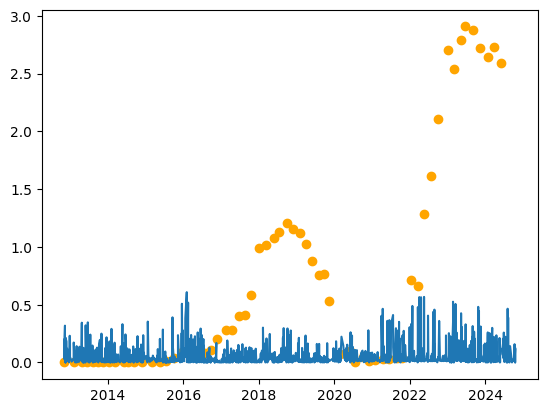

In [70]:
from plotters import PlotCols
import matplotlib.pyplot as plt
df.index = pd.to_datetime(df.index)
plt.figure()
plt.plot(model['test_data']['calculation_date'],model['test_data']['v0'])
plt.scatter(df.index,df['outofsample_MAE'],color='orange')
plt.show()


In [49]:
df

,outofsample_MAE,outofsample_RMSE
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
62,NaN,NaN
63,NaN,NaN
64,NaN,NaN
65,NaN,NaN


In [ ]:
from plotters import PlotCols
PlotCols(df)

In [ ]:
retrained = {'errors':df,'models':models}
tag = ms.timetag()
joblib.dump(retrained,f'{tag} retrained_relative_{pricename}_options.pkl')